In [15]:
import numpy as np
import lmfit

from General.experiments.hdf5.readHDF5 import read_hdf5
from General.experiments.waveforms import MeasuredWaveforms
from General.plotting import plot, cbar

out_loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Tex\Images\Method'

In [10]:
loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Results\Air_3slm_Ar_1slm_9kV_1us.hdf5'
data = read_hdf5(loc)
waveform_data = data['waveforms']
waveforms = MeasuredWaveforms.from_waveforms(waveform_data, channels={1: 'voltage', 2: 'current', 3: 'pulse_generator', 4: 'ground_current'})

C:\Users\20222772\PycharmProjects\MasterDataAnalysis\General\plotting\plot.py:353: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


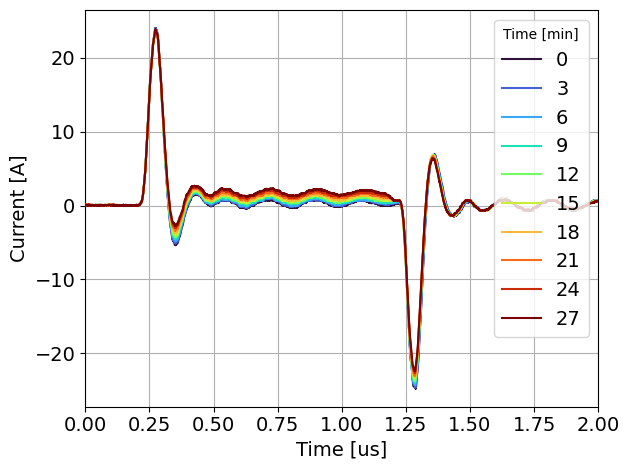

In [11]:
is_on = waveforms.is_on()
num = np.sum(is_on.astype(int))
values = np.argwhere(np.diff(is_on.astype(int)) == 1)[0][0] + np.linspace(10, num-52, 10, dtype=int)
indexes = values + np.arange(20, dtype=int)[:, None]

times = np.mean(waveforms.time[indexes], axis=0)
currents = np.mean(waveforms.currents[indexes], axis=0)
rel_times = waveforms.time_offset[values]
rel_times = rel_times - rel_times[0]
colors, _ = cbar.cbar_norm_colors(rel_times)
labels = [f'{rel_time/60:.0f}' for rel_time in rel_times]

plot_kwargs = {'xlabel': 'Time [us]', 'ylabel': 'Current [A]', 'xlim': (0, 2)}
legend_kwargs= {'title': 'Time [min]', 'loc': 'upper right'}
save_loc = rf'{out_loc}\currents.pdf'
plot.lines(1e6*times, currents, colors=colors, labels=labels, plot_kwargs=plot_kwargs, legend_kwargs=legend_kwargs, save_loc=save_loc)

C:\Users\20222772\AppData\Local\Temp\ipykernel_5316\1604561628.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


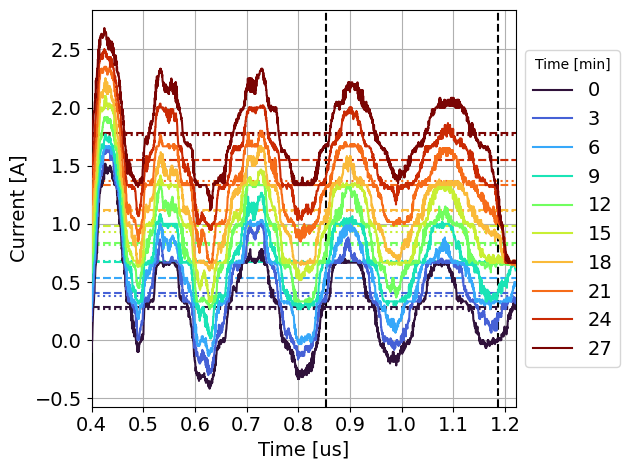

In [27]:
end_time = np.average(waveforms.time, axis=0)[np.argmin(np.average(waveforms.currents, axis=0))] - 1e-7

vals, stds = waveforms.background_current_averaging(1)
vals, stds = vals[values], stds[values]

mask = (waveforms.time[0] > end_time - 1e-6/3) & (waveforms.time[0] < end_time)
model = waveforms._background_current_fitting_model
lmfit_model = lmfit.Model(model)
lmfit_model.set_param_hint('amplitude', value=0.25, min=0)
lmfit_model.set_param_hint('decay', value=2e-6)
lmfit_model.set_param_hint('phase', value=-1.5)
lmfit_model.set_param_hint('length', value=1.9e-7)
lmfit_model.set_param_hint('offset', value=0.8)
params = lmfit_model.make_params()

vals2 = np.zeros_like(vals)
for index, (tim, current) in enumerate(zip(times, currents)):
    result = lmfit_model.fit(current[mask], params, x=tim[mask])
    vals2[index] = result.best_values['offset']
    params = result.params

plot_kwargs = {'xlabel': 'Time [us]', 'ylabel': 'Current [A]', 'xlim': (0.4, 1.22)}
legend_kwargs = {'loc': 'center left', 'bbox_to_anchor': (1, 0.5), 'title':'Time [min]'}
fig, ax = plot.lines(1e6*times, currents, colors=colors, labels=labels, plot_kwargs=plot_kwargs, legend_kwargs=legend_kwargs, show=False)
ax.axvline(end_time*1e6, color='black', linestyle='--')
ax.axvline((end_time)*1e6-(1/3), color='black', linestyle='--')
for i, (value, std) in enumerate(zip(vals, stds)):
    ax.axhline(value, color=colors[i], linestyle=':')
    ax.axhline(vals2[i], color=colors[i], linestyle='--')
fig.show()
